# Portugal Bank Marketing

In [1]:
import numpy as np
import pandas as pd
import random
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import GridSearchCV

In [2]:
df=pd.read_csv("bank.csv",sep=';')

In [3]:
df=df.drop(['duration'],axis=1)
print(df.shape)
df.head()

(41188, 20)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


We have dropped the 'duration' variable as the value of the variable will only be known at the end of the call. Hence, at that time we will also know the outcome of the call. The 'duration' variable will lead to leakage in the data and the prediction model will not be realistic.

# Exploratory Analysis:

Categorical Variables:

We first start the exploratory analysis of the categorical variables and see what are the categories and are there any missing values for these categories. Here, we used the seaborn package to create the bar graphs below.

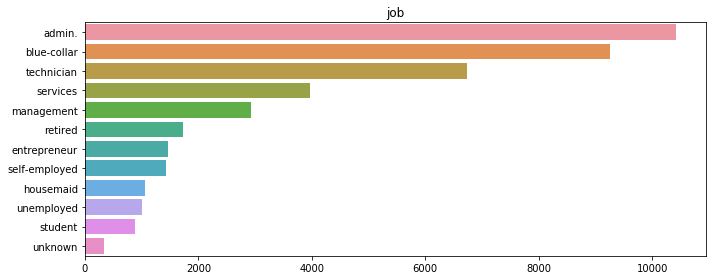

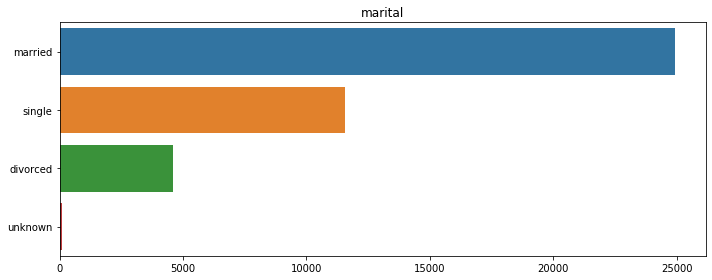

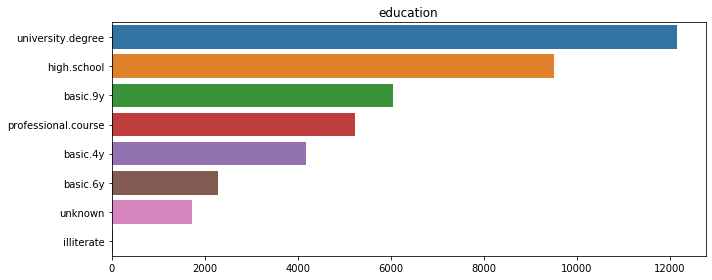

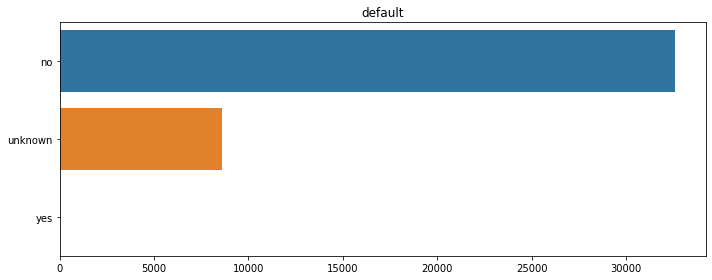

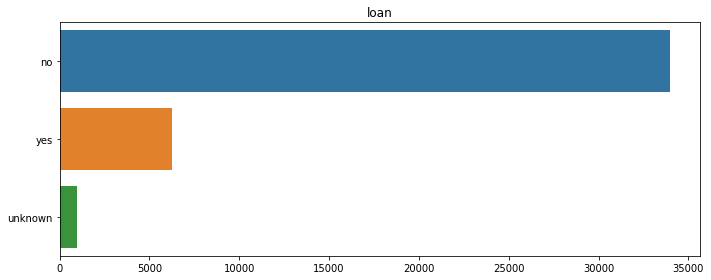

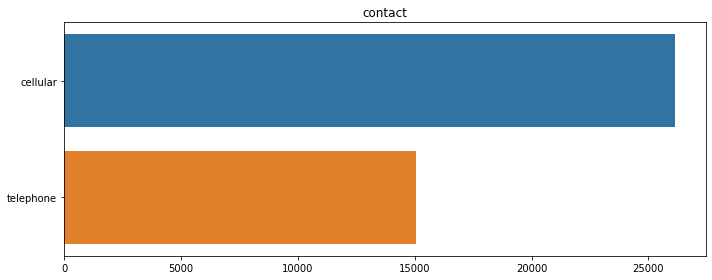

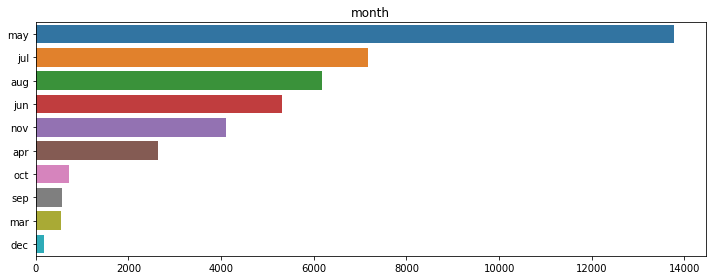

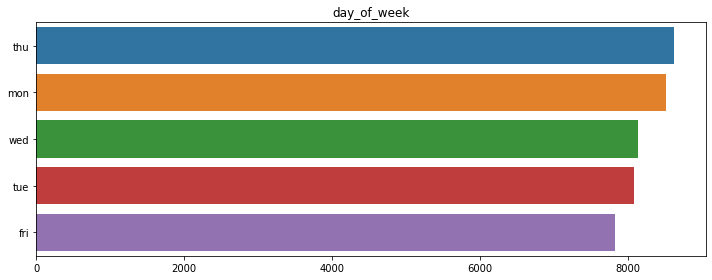

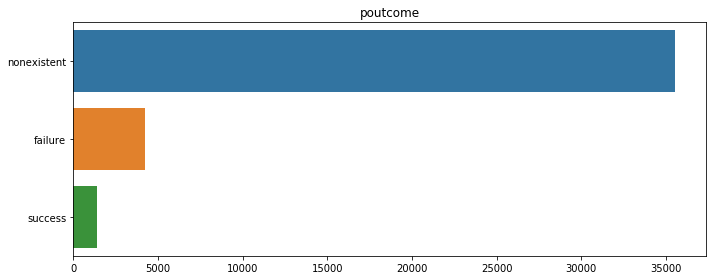

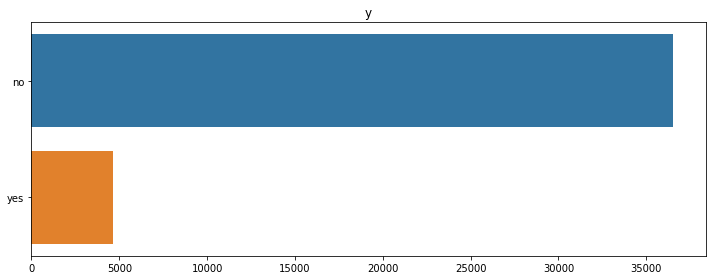

In [4]:
categorcial_variables = ['job', 'marital', 'education', 'default', 'loan', 'contact', 'month', 'day_of_week', 'poutcome','y']
for col in categorcial_variables:
    plt.figure(figsize=(10,4))
    sns.barplot(df[col].value_counts().values, df[col].value_counts().index)
    plt.title(col)  
    plt.tight_layout()

# List of normalized relative frequency of the target class per category.

Normalized distribution of each class per feature and plotted difference between positive and negative frequencies. Positive values imply this category favors clients that will subscribe and negative values categories that favor not buying the product.

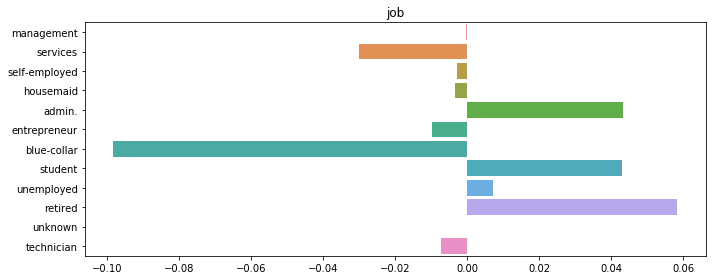

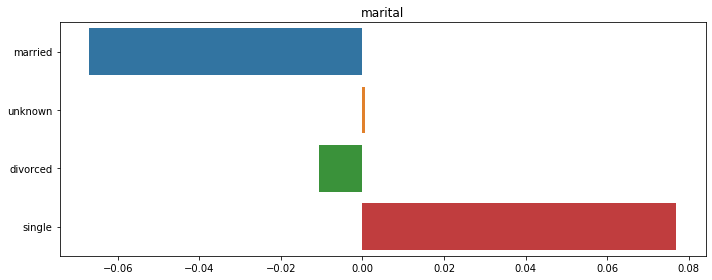

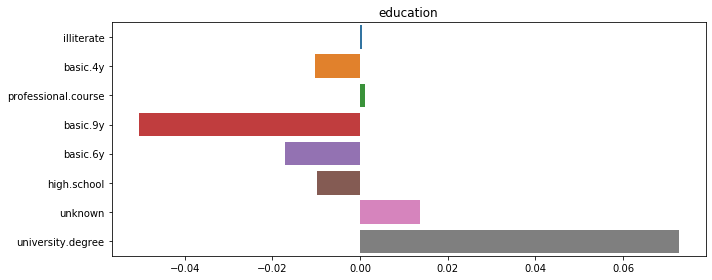

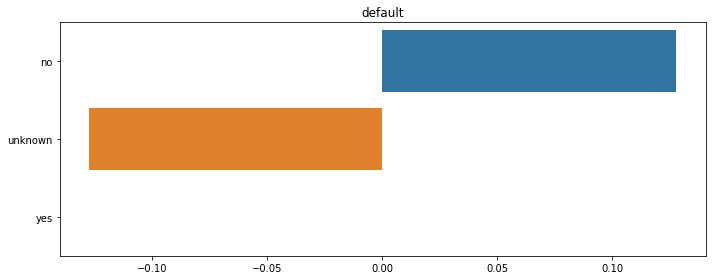

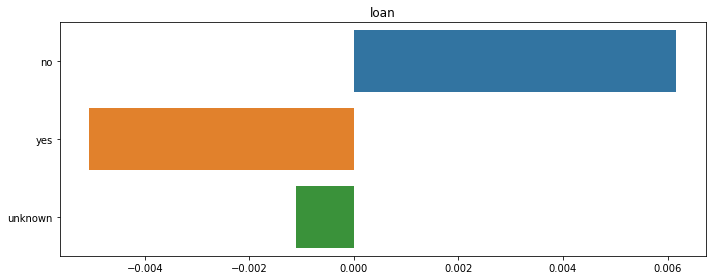

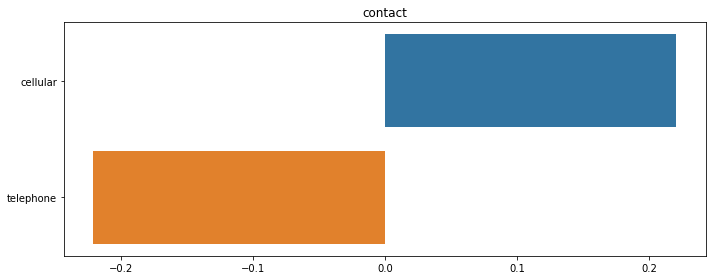

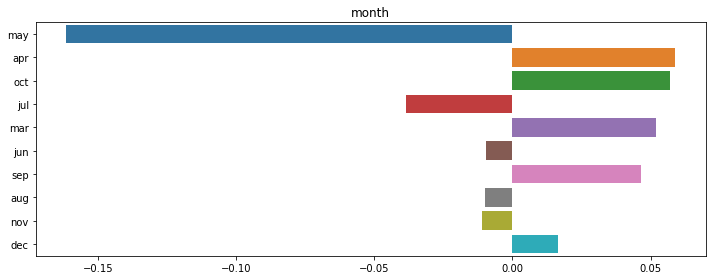

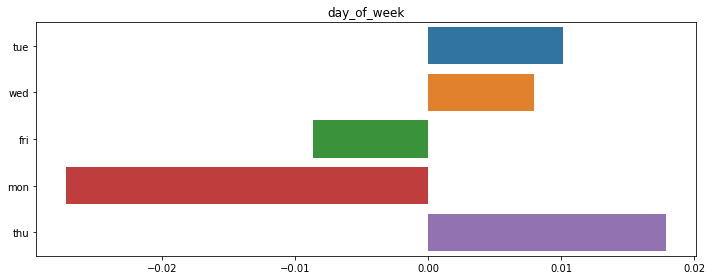

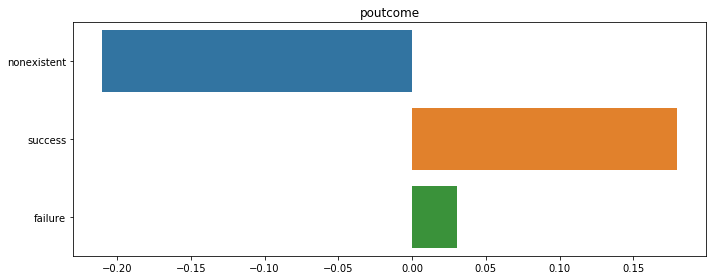

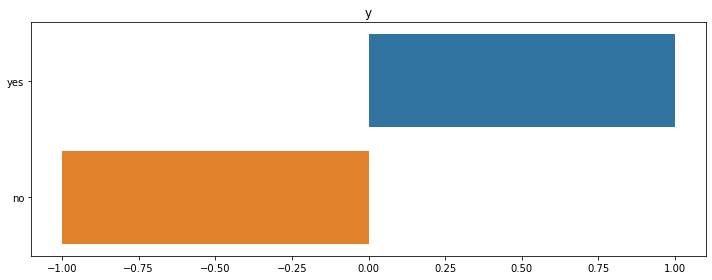

In [5]:
categorcial_variables = ['job', 'marital', 'education', 'default', 'loan', 'contact', 'month', 'day_of_week', 'poutcome','y']
for col in categorcial_variables:
    plt.figure(figsize=(10,4))
    #Returns counts of unique values for each outcome for each feature.
    pos_counts = df.loc[df.y.values == 'yes', col].value_counts() 
    neg_counts = df.loc[df.y.values == 'no', col].value_counts()
    
    all_counts = list(set(list(pos_counts.index) + list(neg_counts.index)))
    
    #Counts of how often each outcome was recorded.
    freq_pos = (df.y.values == 'yes').sum()
    freq_neg = (df.y.values == 'no').sum()
    
    pos_counts = pos_counts.to_dict()
    neg_counts = neg_counts.to_dict()
    
    all_index = list(all_counts)
    all_counts = [pos_counts.get(k, 0) / freq_pos - neg_counts.get(k, 0) / freq_neg for k in all_counts]

    sns.barplot(all_counts, all_index)
    plt.title(col)
    plt.tight_layout()

In [6]:
## Creating new variables (variable name + '_un') to capture the information if the missing values are at random or is there
## a pattern in the missing values.
significant_cat_variables = ['education','job','housing','loan']
for var in significant_cat_variables:
    #df[var + '_un'] = 0
    #df[var + '_un'][df[var]=='unknown'] = 1
    #FIXME one-line coding
    df[var + '_un'] = (df[var] == 'unknown').astype(int)

# Imputation:

Now, to infer the missing values in 'job' and 'education', we make use of the cross-tabulation between 'job' and 'education'. Our hypothesis here is that 'job' is influenced by the 'education' of a person. Hence, we can infer 'job' based on the education of the person. Moreover, since we are just filling the missing values, we are not much concerned about the causal inference. We, therefore, can use the job to predict the education.

In [7]:
def cross_tab(df,f1,f2):
    jobs=list(df[f1].unique())
    edu=list(df[f2].unique())
    dataframes=[]
    for e in edu:
        dfe=df[df[f2]==e]
        dfejob=dfe.groupby(f1).count()[f2]
        dataframes.append(dfejob)
    xx=pd.concat(dataframes,axis=1)
    xx.columns=edu
    xx=xx.fillna(0)
    return xx

In [8]:
cross_tab(df,'job','education')

,basic.4y,high.school,basic.6y,basic.9y,professional.course,unknown,university.degree,illiterate
admin.,77,3329,151,499,363,249,5753,1.0
blue-collar,2318,878,1426,3623,453,454,94,8.0
entrepreneur,137,234,71,210,135,57,610,2.0
housemaid,474,174,77,94,59,42,139,1.0
management,100,298,85,166,89,123,2063,0.0
retired,597,276,75,145,241,98,285,3.0
self-employed,93,118,25,220,168,29,765,3.0
services,132,2682,226,388,218,150,173,0.0
student,26,357,13,99,43,167,170,0.0
technician,58,873,87,384,3320,212,1809,0.0


In [9]:
df['job'][df['age']>60].value_counts()

retired          678
housemaid         54
admin.            47
technician        34
management        30
unknown           21
blue-collar       20
self-employed      9
entrepreneur       8
unemployed         7
services           2
Name: job, dtype: int64

While imputing the values for job and education, we were cognizant of the fact that the correlations should make real world sense. If it didn't make real world sense, we didn't replace the missing values

In [10]:
df.loc[(df['age']>60) & (df['job']=='unknown'), 'job'] = 'retired'
df.loc[(df['education']=='unknown') & (df['job']=='management'), 'education'] = 'university.degree'
df.loc[(df['education']=='unknown') & (df['job']=='services'), 'education'] = 'high.school'
df.loc[(df['education']=='unknown') & (df['job']=='housemaid'), 'education'] = 'basic.4y'
df.loc[(df['job'] == 'unknown') & (df['education']=='basic.4y'), 'job'] = 'blue-collar'
df.loc[(df['job'] == 'unknown') & (df['education']=='basic.6y'), 'job'] = 'blue-collar'
df.loc[(df['job'] == 'unknown') & (df['education']=='basic.9y'), 'job'] = 'blue-collar'
df.loc[(df['job']=='unknown') & (df['education']=='professional.course'), 'job'] = 'technician'

In [11]:
cross_tab(df,'job','education')

,basic.4y,high.school,basic.6y,basic.9y,professional.course,unknown,university.degree,illiterate
admin.,77.0,3329,151.0,499.0,363.0,249.0,5753,1.0
blue-collar,2366.0,878,1448.0,3654.0,453.0,454.0,94,8.0
entrepreneur,137.0,234,71.0,210.0,135.0,57.0,610,2.0
housemaid,516.0,174,77.0,94.0,59.0,0.0,139,1.0
management,100.0,298,85.0,166.0,89.0,0.0,2186,0.0
retired,601.0,276,75.0,145.0,243.0,112.0,286,3.0
self-employed,93.0,118,25.0,220.0,168.0,29.0,765,3.0
services,132.0,2832,226.0,388.0,218.0,0.0,173,0.0
student,26.0,357,13.0,99.0,43.0,167.0,170,0.0
technician,58.0,873,87.0,384.0,3330.0,212.0,1809,0.0


As we can see, we are able to reduce the number of unknowns and enhance our data set.

In [12]:
jobhousing=cross_tab(df,'job','housing')
jobloan=cross_tab(df,'job','loan')

Imputations for house and loan : 

In [13]:
def fillhousing(df,jobhousing):
    """Function for imputation via cross-tabulation to fill missing values for the 'housing' categorical feature"""
    jobs=['housemaid','services','admin.','blue-collar','technician','retired','management','unemployed','self-employed','entrepreneur','student']
    house=["no","yes"]
    for j in jobs:
        ind=df[np.logical_and(np.array(df['housing']=='unknown'),np.array(df['job']==j))].index
        mask=np.random.rand(len(ind))<((jobhousing.loc[j]['no'])/(jobhousing.loc[j]['no']+jobhousing.loc[j]['yes']))
        ind1=ind[mask]
        ind2=ind[~mask]
        df.loc[ind1,"housing"]='no'
        df.loc[ind2,"housing"]='yes'
    return df

In [14]:
def fillloan(df,jobloan):
    """Function for imputation via cross-tabulation to fill missing values for the 'loan' categorical feature"""
    jobs=['housemaid','services','admin.','blue-collar','technician','retired','management','unemployed','self-employed','entrepreneur','student']
    loan=["no","yes"]
    for j in jobs:
        ind=df[np.logical_and(np.array(df['loan']=='unknown'),np.array(df['job']==j))].index
        mask=np.random.rand(len(ind))<((jobloan.loc[j]['no'])/(jobloan.loc[j]['no']+jobloan.loc[j]['yes']))
        ind1=ind[mask]
        ind2=ind[~mask]
        df.loc[ind1,"loan"]='no'
        df.loc[ind2,"loan"]='yes'
    return df

In [15]:
df=fillhousing(df,jobhousing)

In [16]:
df=fillloan(df,jobloan)

# Numerical variables:

Let see the summary of the data in order to understand the numerical variables.

In [17]:
numerical_variables = ['age','campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx','cons.conf.idx','euribor3m',
                      'nr.employed']
df[numerical_variables].describe()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


# Missing Values in Numerical Variables

Let's examine the missing values in 'pdays'

In [18]:
def drawhist(df,feature):
    plt.hist(df[feature])

Filtered out missing values encoded with an out-of-range value when plotting the histogram of values in order to properly understand the distribution of the known values. Here, histograms were created using matplotlib.

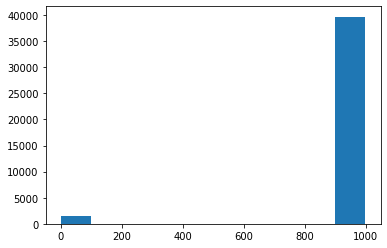

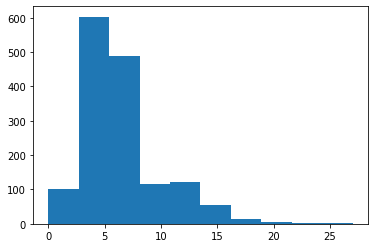

In [19]:
drawhist(df,'pdays')
plt.show()

plt.hist(df.loc[df.pdays != 999, 'pdays'])
plt.show()

In [20]:
pd.crosstab(df['pdays'],df['poutcome'], values=df['age'], aggfunc='count', normalize=True)

poutcome,failure,nonexistent,success
pdays,,,
0,0.000000,0.000000,0.000364
1,0.000000,0.000000,0.000631
2,0.000000,0.000000,0.001481
3,0.000097,0.000000,0.010561
4,0.000049,0.000000,0.002816
5,0.000097,0.000000,0.001020
6,0.000607,0.000000,0.009396
7,0.000364,0.000000,0.001093
8,0.000146,0.000000,0.000291


As we can see from the above table, the majority of the values for 'pdays' are missing. The majority of these missing values occur when the 'poutcome' is 'non-existent'. This means that the majority of the values in 'pdays' are missing because the customer was never contacted before. To deal with this variable, we removed the numerical variable 'pdays' and replaced it with categorical variables with following categories: p_days_missing, pdays_less_5, pdays_bet_5_15, and pdays_greater_15.

In [21]:
#Add new categorical variables to our dataframe.
df['pdays_missing'] = 0
df['pdays_less_5'] = 0
df['pdays_greater_15'] = 0
df['pdays_bet_5_15'] = 0
df['pdays_missing'][df['pdays']==999] = 1
df['pdays_less_5'][df['pdays']<5] = 1
df['pdays_greater_15'][(df['pdays']>15) & (df['pdays']<999)] = 1
df['pdays_bet_5_15'][(df['pdays']>=5)&(df['pdays']<=15)]= 1
df_dropped_pdays = df.drop('pdays', axis=1);

Since we have many categorical variables, dummy variables needs to be created for those vaiables.

In [22]:
df_with_dummies=pd.get_dummies(df_dropped_pdays)

Drop one of the dummy variables as for $n$ categories we only need $n$-1 dummy variables.

In [23]:
def dropfeature(df,f):
    """Drops one of the dummy variables."""
    df=df.drop(f,axis=1)
    return df

In [24]:
features_dropped = ['default_no','housing_no','loan_no','y_no','marital_single','contact_cellular',
                    'education_unknown','job_unknown','housing_unknown','loan_unknown', 'pdays_less_5']
df_clean = dropfeature(df_with_dummies, features_dropped)

# Some helper functions to build and evaluate the models

In [25]:

def drawheatmap(df):
    '''Builds the heat map for the given data'''
    f, ax = plt.subplots(figsize=(15, 15))
    sns.heatmap(df.corr(method='spearman'), annot=False, cmap='coolwarm')
    
def drawhist(df,feature):
    '''Draws an histogram for a feature in a data frame (df)'''
    plt.hist(df[feature])

def functionreplace(df,fea,val1,val2):
    '''Replaces value (val1) with value (val2) in the data frame (df) for a feature (fea)'''
    df[fea].replace(val1,val2)
    return df

def drawbarplot(df,x,y):
    '''Draws a bar plot for a given feature x and y in a data frame'''
    sns.barplot(x=x, y=y, data=df)

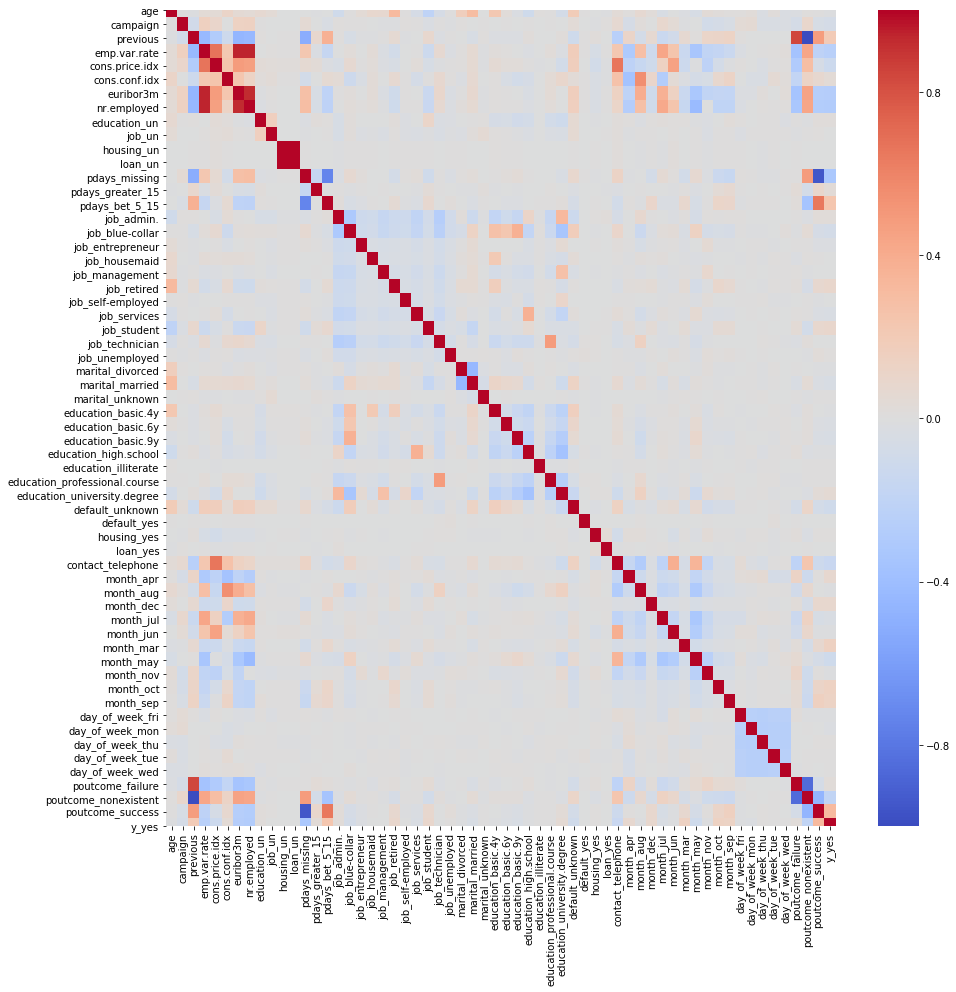

In [26]:
drawheatmap(df_clean)

Inferences: From the above heat map we can see that 'y_yes' (our target variable) has good correlation with 'previous', 'emp.var.rate', 'euribor3m', 'nr.employed', 'pdays_missing', 'poutcome_success' , 'poutcome_nonexistent'and 'pdays_bet_5_15'. We expect to see these independent variables as significant while building the models.

In [27]:
def getmeanauc(aucs,model):
    ''' Calculates the mean AUC for all the cross-validated samples and computes the value of C (Regularization Parameter) 
    for which max mean auc is obtained'''
    #Initialize empty array to hold mean AUC values.
    meanauc = []
    maxmean = 0 #Initial value for maximum mean AUC
    models_with_1_param = ['Logistic_Regression' , 'Ada_Boost']
    models_with_2_params = ['Decision_Tree' , 'Random_Forest', 'Grad_Boost']
    for c in aucs: #For loop to append AUC value to meanauc array.
        meanauc.append(np.mean(aucs[c]))
        if maxmean < np.mean(aucs[c]):
            maxmean = np.mean(aucs[c]) #Adjust value of maxmean
            cval = c
    if model in models_with_1_param:
        print("C value for max auc is: ",cval)
        print("Max Mean Auc corresponding to the optimal value of C = ", maxmean)
        return meanauc,cval
    if model in models_with_2_params:
        listSL=cval.split('L')
        splitval=int(listSL[0]) #Stores minimum split value for max AUC
        leafval=int(listSL[1]) #Stores minimum leaf value for max AUC
        print("min_sample_split value for max auc is:",splitval)
        print("min_sample_leaf value for max auc is:",leafval)
        print("Max mean AUC corresponding to optimal leaf and split value = ",maxmean)
        return meanauc,splitval,leafval
    
def plot_mean_auc_LR(aucs,cs, label):
    '''Plots different values of mean auc versus the hyperparameter C'''
    plt.plot(np.log10(cs),aucs, label = label )
    plt.xlabel("C (Regularization Parameter)")
    plt.ylabel("Mean AUC")
    plt.legend()
        
def plotfeatureimportances(train, importance):
    '''Plots feature importance in a sorted order and shows the most significant variables at the top'''
    X = list(train.columns)
    X.remove('y_yes')
    feature_importance_df = pd.DataFrame(data = importance, index = X, columns=['coefficient_values'])
    feature_importance_df['sort'] = feature_importance_df.coefficient_values.abs()
    sorted_feature_imp_df = feature_importance_df.sort_values(by='sort', ascending=False).drop('sort', axis=1)
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 15)
    sns.barplot(np.array(sorted_feature_imp_df.coefficient_values), np.array(sorted_feature_imp_df.index.values))
    plt.title('Feature Importances')
    plt.xlabel('Coefficients')
    plt.ylabel('Feature Names')
    
def plotfeatureimp(fl,col):
    '''Plots the feature importance of all the independent variables in the model'''
    f=plt.figure(figsize=(10,15))
    plt.barh(range(len(fl)),fl)
    plt.yticks(range(len(col[:-1])),col[:-1])
    
def plotAUCDTRF(aucs,leafs,splits):
    '''Plots AUC for each value of Leaf and Split combination'''
    for i in range(len(splits)):
        plt.plot(leafs,aucs[len(leafs)*i:len(leafs)*i+len(leafs)], label = 'Split value= ' + str(splits[i]))
    plt.legend()
    plt.xlabel('Leaf Values')
    plt.ylabel('Mean AUC')
    
def plot_mean_auc_Ada_Boost(aucs, estimators, label):
    '''Plots different values of mean auc versus the Estimators for AdaBoosting'''
    plt.plot(estimators,aucs, label = label )
    plt.xlabel("Estimators")
    plt.ylabel("Mean AUC")
    plt.legend()

In [32]:
df_clean.head()

,age,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,education_un,job_un,...,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,y_yes
0,56,1,0,1.1,93.994,-36.4,4.857,5191.0,0,0,...,0,0,1,0,0,0,0,1,0,0
1,57,1,0,1.1,93.994,-36.4,4.857,5191.0,0,0,...,0,0,1,0,0,0,0,1,0,0
2,37,1,0,1.1,93.994,-36.4,4.857,5191.0,0,0,...,0,0,1,0,0,0,0,1,0,0
3,40,1,0,1.1,93.994,-36.4,4.857,5191.0,0,0,...,0,0,1,0,0,0,0,1,0,0
4,56,1,0,1.1,93.994,-36.4,4.857,5191.0,0,0,...,0,0,1,0,0,0,0,1,0,0


# Model Building and Evaluation

In [33]:
# Saperating features and result vectors
X = df_clean.drop('y_yes', axis=1).values
y = df_clean['y_yes'].values

In [35]:
#Split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [36]:
# check the column shape
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(28831, 59)
(12357, 59)
(28831,)
(12357,)


# Logistic Regression Model

In [44]:
from sklearn.linear_model import LogisticRegression
glm = LogisticRegression()

model = glm.fit(X_train,y_train)
predicted = model.predict(X_test)

In [45]:
predicted

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [46]:
from sklearn.metrics import accuracy_score
pred = model.predict(X_test)  #by defalut
#pred = np.where(pred_prob > 0.3,1,0)
pred_prob = model.predict_proba(X_test)[:,1]

print("accuracy:",accuracy_score(y_test,predicted))
#print('accuracy_manual:', (TP + TN)/(TP + TN + FP + FN))

accuracy: 0.8958485069191552


In [47]:
# classification_report
from sklearn.metrics import classification_report
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94     10968
           1       0.61      0.21      0.31      1389

    accuracy                           0.90     12357
   macro avg       0.76      0.60      0.63     12357
weighted avg       0.87      0.90      0.87     12357



In [51]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score,roc_curve

# Function For Logistic Regression Create Summary For Logistic Regression

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle=':')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

def get_summary(y_test,predicted):
    # Confusion Matrix
    confusion = confusion_matrix(y_test,predicted)
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    TP = confusion[1, 1]
    
    
    accuracy = (TP+TN)/((FN+FP)+(TP+TN))
    sensitivity = TP/(TP+FN)
    specificity = TN/(TN+FP)
    precision = TP/(TP+FP)
    recall =  TP / (TP + FN)
    fScore = (2 * recall * precision) / (recall + precision)
    auc = roc_auc_score(y_test, predicted)
    
    print("Confusion Matrix:\n",confusion)
    print("Accuracy:",accuracy)
    print("Sensitivity :",sensitivity)
    print("Specificity :",specificity)
    print("Precision:",precision)
    print("Recall:",recall)
    print("F-score:",fScore)
    print("AUC:",auc)
    print("ROC curve:")
    fpr, tpr, thresholds = roc_curve(y_test, predicted)
    plot_roc_curve(fpr, tpr)

Confusion Matrix:
 [[10782   186]
 [ 1101   288]]
Accuracy: 0.8958485069191552
Sensitivity : 0.20734341252699784
Specificity : 0.9830415754923414
Precision: 0.6075949367088608
Recall: 0.20734341252699784
F-score: 0.30917874396135264
AUC: 0.5951924940096696
ROC curve:


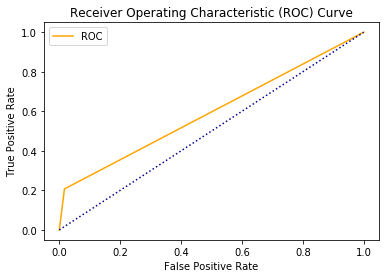

In [52]:
get_summary(y_test,predicted)

# KNN

In [83]:
# Fitting K-NN to the Training set
from sklearn.neighbors import KNeighborsClassifier

from sklearn import metrics
for i in range(1,40,2):
    classifier = KNeighborsClassifier(n_neighbors=i)
#Train the model using the training sets
    classifier.fit(X_train, y_train)
#Predict the response for test dataset
    pred1 = classifier.predict(X_test)
    Accuracy = []  
   # print("Accuracy:",metrics.accuracy_score(y_test,pred1), "for",i)

In [84]:
print(classification_report(y_test,pred1))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94     10968
           1       0.55      0.17      0.26      1389

    accuracy                           0.89     12357
   macro avg       0.73      0.58      0.60     12357
weighted avg       0.86      0.89      0.86     12357



In [85]:
# Function For Logistic Regression Create Summary For Logistic Regression

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle=':')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

def get_summary(y_test,pred1):
    # Confusion Matrix
    confusion = confusion_matrix(y_test,pred1)
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    TP = confusion[1, 1]
    
    
    accuracy = (TP+TN)/((FN+FP)+(TP+TN))
    sensitivity = TP/(TP+FN)
    specificity = TN/(TN+FP)
    precision = TP/(TP+FP)
    recall =  TP / (TP + FN)
    fScore = (2 * recall * precision) / (recall + precision)
    auc = roc_auc_score(y_test, pred1)
    
    print("Confusion Matrix:\n",confusion)
    print("Accuracy:",accuracy)
    print("Sensitivity :",sensitivity)
    print("Specificity :",specificity)
    print("Precision:",precision)
    print("Recall:",recall)
    print("F-score:",fScore)
    print("AUC:",auc)
    print("ROC curve:")
    fpr, tpr, thresholds = roc_curve(y_test, pred1)
    plot_roc_curve(fpr, tpr)

Confusion Matrix:
 [[10776   192]
 [ 1152   237]]
Accuracy: 0.8912357368293276
Sensitivity : 0.17062634989200864
Specificity : 0.9824945295404814
Precision: 0.5524475524475524
Recall: 0.17062634989200864
F-score: 0.2607260726072607
AUC: 0.576560439716245
ROC curve:


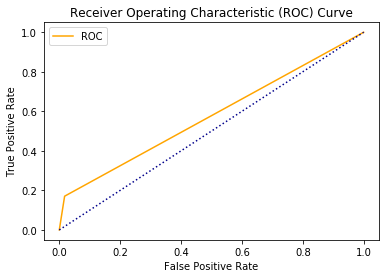

In [86]:
get_summary(y_test,pred1)

# Navie Bayes

In [58]:
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

In [59]:
model = GaussianNB()

In [60]:
model = model.fit(X_train,y_train)

In [61]:
Y_test_pred = model.predict(X_test)

In [62]:
print(model.score(X_test, y_test))
print(confusion_matrix(y_test, Y_test_pred))

0.8670389253054949
[[10091   877]
 [  766   623]]


In [64]:
print(classification_report(y_test,Y_test_pred))

              precision    recall  f1-score   support

           0       0.93      0.92      0.92     10968
           1       0.42      0.45      0.43      1389

    accuracy                           0.87     12357
   macro avg       0.67      0.68      0.68     12357
weighted avg       0.87      0.87      0.87     12357



In [65]:
# Function For Logistic Regression Create Summary For Logistic Regression

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle=':')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

def get_summary(y_test,Y_test_pred):
    # Confusion Matrix
    confusion = confusion_matrix(y_test,Y_test_pred)
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    TP = confusion[1, 1]
    
    
    accuracy = (TP+TN)/((FN+FP)+(TP+TN))
    sensitivity = TP/(TP+FN)
    specificity = TN/(TN+FP)
    precision = TP/(TP+FP)
    recall =  TP / (TP + FN)
    fScore = (2 * recall * precision) / (recall + precision)
    auc = roc_auc_score(y_test,Y_test_pred)

    print("Confusion Matrix:\n",confusion)
    print("Accuracy:",accuracy)
    print("Sensitivity :",sensitivity)
    print("Specificity :",specificity)
    print("Precision:",precision)
    print("Recall:",recall)
    print("F-score:",fScore)
    print("AUC:",auc)
    print("ROC curve:")
    fpr, tpr, thresholds = roc_curve(y_test,Y_test_pred)
    plot_roc_curve(fpr, tpr)

Confusion Matrix:
 [[10091   877]
 [  766   623]]
Accuracy: 0.8670389253054949
Sensitivity : 0.44852411807055437
Specificity : 0.9200401167031363
Precision: 0.41533333333333333
Recall: 0.44852411807055437
F-score: 0.43129110418830047
AUC: 0.6842821173868454
ROC curve:


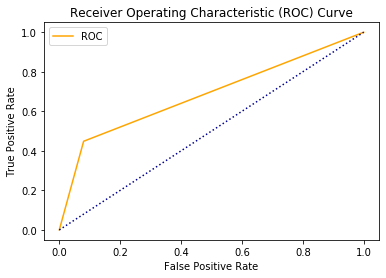

In [66]:
get_summary(y_test,Y_test_pred)

# SVM

In [67]:
#Import svm model
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
pred = clf.predict(X_test)

In [69]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94     10968
           1       0.55      0.20      0.30      1389

    accuracy                           0.89     12357
   macro avg       0.73      0.59      0.62     12357
weighted avg       0.87      0.89      0.87     12357



In [72]:
# Function For Logistic Regression Create Summary For Logistic Regression

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle=':')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

def get_summary(y_test,pred):
    # Confusion Matrix
    confusion = confusion_matrix(y_test,pred)
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    TP = confusion[1, 1]
    
    
    accuracy = (TP+TN)/((FN+FP)+(TP+TN))
    sensitivity = TP/(TP+FN)
    specificity = TN/(TN+FP)
    precision = TP/(TP+FP)
    recall =  TP / (TP + FN)
    fScore = (2 * recall * precision) / (recall + precision)
    auc = roc_auc_score(y_test,pred)

    print("Confusion Matrix:\n",confusion)
    print("Accuracy:",accuracy)
    print("Sensitivity :",sensitivity)
    print("Specificity :",specificity)
    print("Precision:",precision)
    print("Recall:",recall)
    print("F-score:",fScore)
    print("AUC:",auc)
    print("ROC curve:")
    fpr, tpr, thresholds = roc_curve(y_test,pred)
    plot_roc_curve(fpr, tpr)

Confusion Matrix:
 [[10738   230]
 [ 1107   282]]
Accuracy: 0.8918022173666748
Sensitivity : 0.20302375809935205
Specificity : 0.9790299051787017
Precision: 0.55078125
Recall: 0.20302375809935205
F-score: 0.2966859547606523
AUC: 0.5910268316390269
ROC curve:


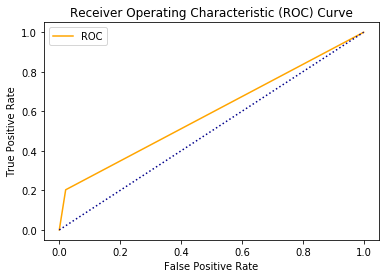

In [73]:
get_summary(y_test,pred)

# AdaBoost

In [74]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [75]:
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),n_estimators=200)

In [76]:
adafit =ada.fit(X_train,y_train)

In [77]:
adafit

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

In [78]:
Y_predADA = ada.predict(X_test)

In [79]:
len(Y_predADA)

12357

In [80]:
print(classification_report(y_test,Y_predADA))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95     10968
           1       0.67      0.23      0.35      1389

    accuracy                           0.90     12357
   macro avg       0.79      0.61      0.65     12357
weighted avg       0.88      0.90      0.88     12357



In [81]:
# Function For Logistic Regression Create Summary For Logistic Regression

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle=':')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

def get_summary(y_test,Y_predADA):
    # Confusion Matrix
    confusion = confusion_matrix(y_test,Y_predADA)
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    TP = confusion[1, 1]
    
    
    accuracy = (TP+TN)/((FN+FP)+(TP+TN))
    sensitivity = TP/(TP+FN)
    specificity = TN/(TN+FP)
    precision = TP/(TP+FP)
    recall =  TP / (TP + FN)
    fScore = (2 * recall * precision) / (recall + precision)
    auc = roc_auc_score(y_test,Y_predADA)

    print("Confusion Matrix:\n",confusion)
    print("Accuracy:",accuracy)
    print("Sensitivity :",sensitivity)
    print("Specificity :",specificity)
    print("Precision:",precision)
    print("Recall:",recall)
    print("F-score:",fScore)
    print("AUC:",auc)
    print("ROC curve:")
    fpr, tpr, thresholds = roc_curve(y_test,Y_predADA)
    plot_roc_curve(fpr, tpr)

Confusion Matrix:
 [[10091   877]
 [  766   623]]
Accuracy: 0.8670389253054949
Sensitivity : 0.44852411807055437
Specificity : 0.9200401167031363
Precision: 0.41533333333333333
Recall: 0.44852411807055437
F-score: 0.43129110418830047
AUC: 0.6842821173868454
ROC curve:


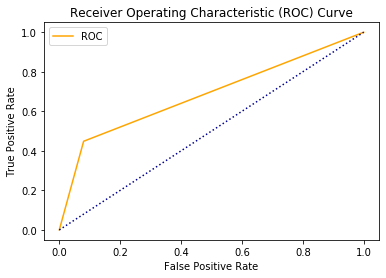

In [82]:
get_summary(y_test,Y_test_pred)